In [4]:
%matplotlib inline

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer

from statsmodels.tools import eval_measures
import statsmodels.formula.api as smf


from warnings import filterwarnings
filterwarnings('ignore')

folder_path = './data/'

t_features = pd.read_csv('data/train_features.csv', index_col=[0,1,2])
t_labels = pd.read_csv('data/train_labels.csv', index_col=[0,1,2])

print(t_labels.groupby('city').count())
# print(t_labels.head())


      total_cases
city             
iq            520
sj            936


In [5]:
features = ['reanalysis_specific_humidity_g_per_kg', 
                 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 
                'station_min_temp_c',
            'precipitation_amt_mm']





def separate_and_engineer(city, data, selected_features, labels, mv1, mv2, mv3, mv4):
    
    data['week_start_date'] = pd.to_datetime(data['week_start_date'])
    for i in range(1,5):
        data['quarter_' + str(i)] = data['week_start_date'].apply(lambda date: 1 if (
            ((i-1)*3<date.to_pydatetime().month) and (date.to_pydatetime().month <= i * 3)) else 0)
        selected_features.append('quarter_' + str(i))
    
    city_train_features = data.loc[city]
    selected_features = list(set(selected_features))
    
    city_train_features = city_train_features.select_dtypes(include=[np.number])
    city_train_features = city_train_features[selected_features]
    
    city_train_features['station_avg_temp_c_mv_avg'] = city_train_features['station_avg_temp_c'].rolling(window=mv1).mean()
    
    city_train_features['precipitation_amt_mm_mv_avg'] = city_train_features['precipitation_amt_mm'].rolling(window=mv2).mean()
    
    city_train_features['reanalysis_specific_humidity_g_per_kg_mv_avg'] = city_train_features['reanalysis_specific_humidity_g_per_kg'].rolling(window=mv3).mean()
    
    city_train_features['reanalysis_dew_point_temp_k_mv_avg'] = city_train_features['reanalysis_dew_point_temp_k'].rolling(window=mv4).mean()
    
    
    city_train_features = city_train_features.fillna(city_train_features.mean())
    
    if (type(labels) != type(None)):
        city_train_labels = labels.loc[city]
        city_train_labels = city_train_labels.fillna(city_train_labels.mean())
    
        return pd.concat([city_train_features, city_train_labels], axis=1)
    
    return city_train_features   


In [6]:
def get_best_model(train, test):
    # Step 1: specify the form of the model
    model_formula = " + ".join(["total_cases ~ 1",
    "station_avg_temp_c_mv_avg",
    "precipitation_amt_mm_mv_avg",
    "reanalysis_specific_humidity_g_per_kg",
    "reanalysis_dew_point_temp_k",
    "precipitation_amt_mm",
    "station_min_temp_c",
    "station_avg_temp_c",
    "reanalysis_specific_humidity_g_per_kg_mv_avg",
    "reanalysis_dew_point_temp_k_mv_avg",
                               "quarter_1",
                               "quarter_2",
                               "quarter_3",
                               "quarter_4"])
    
    grid = 10 ** np.arange(-8, -3, dtype=np.float64)
                    
    best_alpha = []
    best_score = 1000
        
    # Step 2: Find the best hyper parameter, alpha
    for alpha in grid:
        model = smf.glm(formula=model_formula,
                        data=train,
                        family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)

        if score < best_score:
            best_alpha = alpha
            best_score = score

#     print('best alpha = ', best_alpha)
#     print('best score = ', best_score)
            
    # Step 3: refit on entire dataset
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula,
                    data=full_dataset,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model, best_score

In [7]:
# sj_cols_with_missing_values = [col for col in sj_X_train.columns if sj_X_train[col].isnull().any()]

sj_best_final_model = None
iq_best_final_model = None

sj_best_final_score = 1000
iq_best_final_score = 1000

sj_i_j = None
iq_i_j = None


# for i in range(2, 40):
#     for j in range(2, 40):
sj_train = separate_and_engineer('sj', t_features, features, t_labels, 22, 39, 27, 18)
iq_train = separate_and_engineer('iq', t_features, features, t_labels, 34, 33, 2, 2)

sj_train_subtrain = sj_train.head(800)
sj_train_subtest = sj_train.tail(sj_train.shape[0] - 800)

iq_train_subtrain = iq_train.head(450)
iq_train_subtest = iq_train.tail(iq_train.shape[0] - 450)

# print("SJ:\n\n")

# print("IQ:\n\n", iq_train.head())

sj_best_model, sj_best_score = get_best_model(sj_train_subtrain, sj_train_subtest)
iq_best_model, iq_best_score = get_best_model(iq_train_subtrain, iq_train_subtest)

if sj_best_score < sj_best_final_score:
    sj_best_final_score = sj_best_score
    sj_best_final_model = sj_best_model
# #     sj_i_j = [i,j]

if iq_best_score < iq_best_final_score:
    iq_best_final_score = iq_best_score
    iq_best_final_model = iq_best_model
# #     iq_i_j = [i,j]


print("Best MAE (SJ):")
print(sj_best_final_score)


print("\n\nBest MAE (IQ):")
print(iq_best_final_score)
# sj_train.head()


Best MAE (SJ):
10.602941176470589


Best MAE (IQ):
3.4714285714285715


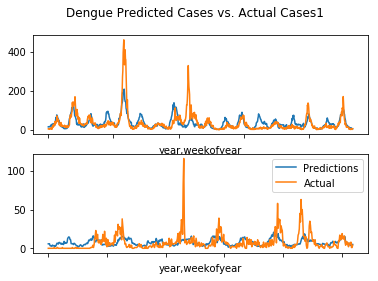

In [8]:
figs, axes = plt.subplots(nrows=2, ncols=1)

# plot sj
sj_train['fitted'] = sj_best_final_model.predict(sj_train)
sj_train.fitted.plot(ax=axes[0], label="Predictions")
sj_train.total_cases.plot(ax=axes[0], label="Actual")

# plot iq
iq_train['fitted'] = iq_best_final_model.predict(iq_train)
iq_train.fitted.plot(ax=axes[1], label="Predictions")
iq_train.total_cases.plot(ax=axes[1], label="Actual")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases1")
plt.legend()

In [13]:
### Random Forest model kernel submission
###

testData = pd.read_csv('data/dengue_features_test.csv', index_col=[0,1,2])

sj_test = separate_and_engineer('sj', testData, features, None, 22, 39, 5, 10)
iq_test = separate_and_engineer('iq', testData, features, None, 34, 33, 5, 10)

sj_predictions = sj_best_final_model.predict(sj_test).astype(int)
iq_predictions = iq_best_final_model.predict(iq_test).astype(int)


submission = pd.read_csv("data/submission .csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions, iq_predictions])
submission.to_csv("benchmark_nb_5.csv")